In [1]:
!git clone https://github.com/vslvskyy/kws

Cloning into 'kws'...
remote: Enumerating objects: 41, done.
remote: Counting objects: 100% (41/41), done.
remote: Compressing objects: 100% (37/37), done.
remote: Total 41 (delta 8), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (41/41), done.


# Imports

In [2]:
from typing import Tuple, Union, List, Callable, Optional
from tqdm import tqdm
from itertools import islice
import pathlib
import dataclasses

import numpy as np
import pandas as pd
import math

import torch
import torch.nn.functional as F
from torch import nn
from torch import distributions
from torch.utils.data import DataLoader, Dataset, WeightedRandomSampler
from torch.nn.utils.rnn import pad_sequence

import torchaudio
from IPython import display as display_

from collections import defaultdict
from IPython.display import clear_output
from matplotlib import pyplot as plt

In [3]:
import random

def set_random_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

set_random_seed()

# Task

In [4]:
@dataclasses.dataclass
class TaskConfig:
    keyword: str = 'sheila'  # We will use 1 key word -- 'sheila'
    batch_size: int = 128
    learning_rate: float = 3e-4
    weight_decay: float = 1e-5
    num_epochs: int = 20
    n_mels: int = 40
    cnn_out_channels: int = 8
    kernel_size: Tuple[int, int] = (5, 20)
    stride: Tuple[int, int] = (2, 8)
    hidden_size: int = 64
    gru_num_layers: int = 2
    bidirectional: bool = False
    num_classes: int = 2
    sample_rate: int = 16000
    device: torch.device = torch.device(
        'cuda:0' if torch.cuda.is_available() else 'cpu')
    max_window_length: int = 130
    streaming_step_size = 40
    t: int = 10
    target_loss_w: float = 0.5

# Quality measurment functions:

In [5]:
# FA - true: 0, model: 1
# FR - true: 1, model: 0

def count_FA_FR(preds, labels):
    FA = torch.sum(preds[labels == 0])
    FR = torch.sum(labels[preds == 0])
    
    # torch.numel - returns total number of elements in tensor
    return FA.item() / torch.numel(preds), FR.item() / torch.numel(preds)


def get_au_fa_fr(probs, labels):
    sorted_probs, _ = torch.sort(probs)
    sorted_probs = torch.cat((torch.Tensor([0]), sorted_probs, torch.Tensor([1])))
    labels = torch.cat(labels, dim=0)
        
    FAs, FRs = [], []
    for prob in sorted_probs:
        preds = (probs >= prob) * 1
        FA, FR = count_FA_FR(preds, labels)        
        FAs.append(FA)
        FRs.append(FR)
    # plt.plot(FAs, FRs)
    # plt.show()

    # ~ area under curve using trapezoidal rule
    return -np.trapz(FRs, x=FAs)

In [ ]:
!pip install thop

In [7]:
import tempfile
import time

from thop import profile


class Timer:

    def __init__(self, name: str, verbose=False):
        self.name = name
        self.verbose = verbose

    def __enter__(self):
        self.t = time.time()
        return self

    def __exit__(self, type, value, traceback):
        self.t = time.time() - self.t

        if self.verbose:
            print(f"{self.name.capitalize()} | Elapsed time : {self.t}")


def get_size_in_megabytes(model):
    # https://pytorch.org/tutorials/recipes/recipes/dynamic_quantization.html#look-at-model-size
    with tempfile.TemporaryFile() as f:
        torch.save(model.state_dict(), f)
        size = f.tell() / 2**20
    return size

# Data

In [ ]:
!wget http://download.tensorflow.org/data/speech_commands_v0.01.tar.gz -O speech_commands_v0.01.tar.gz
!mkdir speech_commands && tar -C speech_commands -xvzf speech_commands_v0.01.tar.gz 1> log

In [9]:
from pickle import FALSE
class SpeechCommandDataset(Dataset):

    def __init__(
        self,
        transform: Optional[Callable] = None,
        path2dir: str = None,
        keywords: Union[str, List[str]] = None,
        csv: Optional[pd.DataFrame] = None,
        return_path: bool = False
    ):        
        self.transform = transform
        self.return_path = return_path

        if csv is None:
            path2dir = pathlib.Path(path2dir)
            keywords = keywords if isinstance(keywords, list) else [keywords]
            
            all_keywords = [
                p.stem for p in path2dir.glob('*')
                if p.is_dir() and not p.stem.startswith('_')
            ]

            triplets = []
            for keyword in all_keywords:
                paths = (path2dir / keyword).rglob('*.wav')
                if keyword in keywords:
                    for path2wav in paths:
                        triplets.append((path2wav.as_posix(), keyword, 1))
                else:
                    for path2wav in paths:
                        triplets.append((path2wav.as_posix(), keyword, 0))
            
            self.csv = pd.DataFrame(
                triplets,
                columns=['path', 'keyword', 'label']
            )

        else:
            self.csv = csv
    
    def __getitem__(self, index: int):
        instance = self.csv.iloc[index]

        path2wav = instance['path']
        wav, sr = torchaudio.load(path2wav)
        wav = wav.sum(dim=0)
        
        if self.transform:
            wav = self.transform(wav)

        if self.return_path:
            return {
                'wav': wav,
                'keyword': instance['keyword'],
                'label': instance['label'],
                'path': path2wav
            }
        return {
                'wav': wav,
                'keyword': instance['keyword'],
                'label': instance['label'],
            }

    def __len__(self):
        return len(self.csv)

In [10]:
dataset = SpeechCommandDataset(
    path2dir='speech_commands', keywords=TaskConfig.keyword
)
dataset.csv.sample(5)

,path,keyword,label
50866,speech_commands/two/f4cae173_nohash_0.wav,two,0
1003,speech_commands/happy/d3a18257_nohash_1.wav,happy,0
38126,speech_commands/right/471a0925_nohash_0.wav,right,0
144,speech_commands/happy/518588b6_nohash_1.wav,happy,0
31651,speech_commands/go/5588c7e6_nohash_0.wav,go,0


In [11]:
my_dataset = SpeechCommandDataset(
    path2dir='kws/my_dataset', keywords=TaskConfig.keyword,
    return_path=True
)
my_dataset.csv

,path,keyword,label
0,kws/my_dataset/sheila/sheila_alphabet.wav,sheila,1
1,kws/my_dataset/sheila/friend_sheila.wav,sheila,1
2,kws/my_dataset/sheila/sheila.wav,sheila,1
3,kws/my_dataset/sheila/sheila_ones.wav,sheila,1
4,kws/my_dataset/not_sheila/alphabet.wav,not_sheila,0
5,kws/my_dataset/not_sheila/friend_alex.wav,not_sheila,0


### Augmentations

In [15]:
class AugsCreation:

    def __init__(self):
        self.background_noises = [
            'speech_commands/_background_noise_/white_noise.wav',
            'speech_commands/_background_noise_/dude_miaowing.wav',
            'speech_commands/_background_noise_/doing_the_dishes.wav',
            'speech_commands/_background_noise_/exercise_bike.wav',
            'speech_commands/_background_noise_/pink_noise.wav',
            'speech_commands/_background_noise_/running_tap.wav'
        ]

        self.noises = [
            torchaudio.load(p)[0].squeeze()
            for p in self.background_noises
        ]

    def add_rand_noise(self, audio):

        # randomly choose noise
        noise_num = torch.randint(low=0, high=len(
            self.background_noises), size=(1,)).item()
        noise = self.noises[noise_num]

        noise_level = torch.Tensor([1])  # [0, 40]

        noise_energy = torch.norm(noise)
        audio_energy = torch.norm(audio)
        alpha = (audio_energy / noise_energy) * \
            torch.pow(10, -noise_level / 20)

        start = torch.randint(
            low=0,
            high=max(int(noise.size(0) - audio.size(0) - 1), 1),
            size=(1,)
        ).item()
        noise_sample = noise[start: start + audio.size(0)]

        audio_new = audio + alpha * noise_sample
        audio_new.clamp_(-1, 1)
        return audio_new

    def __call__(self, wav):
        aug_num = torch.randint(low=0, high=4, size=(1,)).item()   # choose 1 random aug from augs
        augs = [
            lambda x: x,
            lambda x: (x + distributions.Normal(0, 0.01).sample(x.size())).clamp_(-1, 1),
            lambda x: torchaudio.transforms.Vol(.25)(x),
            lambda x: self.add_rand_noise(x)
        ]

        return augs[aug_num](wav)

In [16]:
set_random_seed()
indexes = torch.randperm(len(dataset))
train_indexes = indexes[:int(len(dataset) * 0.8)]
val_indexes = indexes[int(len(dataset) * 0.8):]

train_df = dataset.csv.iloc[train_indexes].reset_index(drop=True)
val_df = dataset.csv.iloc[val_indexes].reset_index(drop=True)

In [17]:
# Sample is a dict of utt, word and label
# train_set = SpeechCommandDataset(csv=train_df, transform=AugsCreation())
val_set = SpeechCommandDataset(csv=val_df)

### Sampler for oversampling:

In [18]:
# We should provide to WeightedRandomSampler _weight for every sample_; by default it is 1/len(target)

def get_sampler(target):
    class_sample_count = np.array(
        [len(np.where(target == t)[0]) for t in np.unique(target)])   # for every class count it's number of occ.
    weight = 1. / class_sample_count
    samples_weight = np.array([weight[t] for t in target])
    samples_weight = torch.from_numpy(samples_weight)
    samples_weigth = samples_weight.float()
    sampler = WeightedRandomSampler(samples_weight, len(samples_weight))
    return sampler

In [19]:
class Collator:
    
    def __call__(self, data):
        wavs, labels, paths = [], [], []

        for el in data:
            wavs.append(el['wav'])
            labels.append(el['label'])
            try:
                paths.append(el['path'])
            except:
              continue

        # torch.nn.utils.rnn.pad_sequence takes list(Tensors) and returns padded (with 0.0) Tensor
        wavs = pad_sequence(wavs, batch_first=True)    
        labels = torch.Tensor(labels).long()
        if len(paths) == len(wavs):
            return wavs, labels, paths
        return wavs, labels

###  Dataloaders

In [20]:
val_loader = DataLoader(val_set, batch_size=TaskConfig.batch_size,
                        shuffle=False, collate_fn=Collator(),
                        num_workers=2, pin_memory=True)

my_loader = DataLoader(my_dataset, batch_size=1,
                        shuffle=False, collate_fn=Collator(),
                        num_workers=2, pin_memory=True)

### Creating MelSpecs on GPU for speeeed: 

In [21]:
class LogMelspec:

    def __init__(self, is_train, config):
        # with augmentations
        if is_train:
            self.melspec = nn.Sequential(
                torchaudio.transforms.MelSpectrogram(
                    sample_rate=config.sample_rate,
                    n_fft=400,
                    win_length=400,
                    hop_length=160,
                    n_mels=config.n_mels
                ),
                torchaudio.transforms.FrequencyMasking(freq_mask_param=15),
                torchaudio.transforms.TimeMasking(time_mask_param=35),
            ).to(config.device)

        # no augmentations
        else:
            self.melspec = torchaudio.transforms.MelSpectrogram(
                sample_rate=config.sample_rate,
                n_fft=400,
                win_length=400,
                hop_length=160,
                n_mels=config.n_mels
            ).to(config.device)

    def __call__(self, batch):
        # already on device
        return torch.log(self.melspec(batch).clamp_(min=1e-9, max=1e9))

In [22]:
melspec_val = LogMelspec(is_train=False, config=TaskConfig)

# Models

In [12]:
class SmallAttention(nn.Module):
    def __init__(self, hidden_size: int, scale: int = 2):
        assert hidden_size >= scale
        super().__init__()

        self.energy = nn.Sequential(
            nn.Linear(hidden_size, hidden_size // scale),
            nn.Tanh(),
            nn.Linear(hidden_size // scale, 1)
        )
    
    def forward(self, input):
        energy = self.energy(input)
        alpha = torch.softmax(energy, dim=-2)
        return (input * alpha).sum(dim=-2)

class Attention(nn.Module):

    def __init__(self, hidden_size: int):
        super().__init__()

        self.energy = nn.Sequential(
            nn.Linear(hidden_size, hidden_size),
            nn.Tanh(),
            nn.Linear(hidden_size, 1)
        )
    
    def forward(self, input):
        energy = self.energy(input)
        alpha = torch.softmax(energy, dim=-2)
        return (input * alpha).sum(dim=-2)

class CRNN(nn.Module):

    def __init__(self, config: TaskConfig):
        super().__init__()
        self.config = config

        self.conv = nn.Sequential(
            nn.Conv2d(
                in_channels=1, out_channels=config.cnn_out_channels,
                kernel_size=config.kernel_size, stride=config.stride
            ),
            nn.Flatten(start_dim=1, end_dim=2),
        )

        self.conv_out_frequency = (config.n_mels - config.kernel_size[0]) // \
            config.stride[0] + 1
        
        self.gru = nn.GRU(
            input_size=self.conv_out_frequency * config.cnn_out_channels,
            hidden_size=config.hidden_size,
            num_layers=config.gru_num_layers,
            dropout=0.1,
            bidirectional=config.bidirectional,
            batch_first=True
        )

        self.attention = Attention(config.hidden_size)
        self.classifier = nn.Linear(config.hidden_size, config.num_classes)
    
    def forward(self, input):
        input = input.unsqueeze(dim=1)
        conv_output = self.conv(input).transpose(-1, -2)
        gru_output, _ = self.gru(conv_output)
        contex_vector = self.attention(gru_output)
        output = self.classifier(contex_vector)
        return output


class StreamingCRNN(CRNN, nn.Module):

    def __init__(self, config: TaskConfig):
        super().__init__(config)
        self.buffer = torch.tensor([])
        self.last_hidden = torch.tensor([])
        self.gru_chunk_buffer: List[torch.tensor] = []
        self.streaming_mode = True

    def forward(self, input, flush=False, max_window_length=101, streaming_step_size=40):
        if self.training or not self.streaming_mode:
            # output = super().forward(input)
            input = input.unsqueeze(dim=1)
            conv_output = self.conv(input).transpose(-1, -2)
            gru_output, _ = self.gru(conv_output)
            contex_vector = self.attention(gru_output)
            output = self.classifier(contex_vector)
            
        else: 
            if flush:
                self.buffer = torch.tensor([])
                self.last_hidden = torch.tensor([])
                self.gru_chunk_buffer = []
                self.streaming_mode = True

            n_input_frames = input.size()[-1]
            max_chunk_n = max_window_length // streaming_step_size

            # набираем буфер (чтобы размерности были больше kernel_size)
            if len(self.buffer) == 0:
                self.buffer = input.unsqueeze(dim=1)
                return None
            elif self.buffer.size()[-1] < self.conv[0].kernel_size[1] - 1:  # self.config.max_window_length:  
                self.buffer = torch.cat((
                    self.buffer,
                    input.unsqueeze(dim=1)
                    ),
                    dim=-1
                )
                return None
            # добавляем в буфер новые фреймы + оставляем kernel_size - 1 пердыдущих
            # чтобы первый фрейм входа был связа с предыдущими
            else:
                self.buffer = torch.cat((
                    self.buffer[:, :, :, -(self.conv[0].kernel_size[1] - 1):],
                    input.unsqueeze(dim=1)
                    ), 
                    dim=-1
                )
            conv_output = self.conv(self.buffer).transpose(-1, -2)

            # применяем gru и сохраняем hidden_state (gru)
            if len(self.last_hidden) == 0:
                gru_output, self.last_hidden = self.gru(conv_output)
            else:
                gru_output, self.last_hidden = self.gru(conv_output, self.last_hidden)

            # заполняем буфер выходов gru
            if len(self.gru_chunk_buffer) == 0:
                self.gru_output_buffer = [gru_output]
            else:
                self.gru_output_buffer.append(gru_output)
                self.gru_output_buffer = self.gru_output_buffer[-max_chunk_n:]
            
            contex_vector = self.attention(torch.cat(self.gru_output_buffer, dim=-2))
            output = self.classifier(contex_vector)
        return output

# Validation Function

In [13]:
@torch.no_grad()
def validation(model, loader, log_melspec, device):
    model.eval()

    val_losses, accs, FAs, FRs = [], [], [], []
    all_probs, all_labels = [], []
    for i, (batch, labels) in tqdm(enumerate(loader), total=len(loader)):
        batch, labels = batch.to(device), labels.to(device)
        batch = log_melspec(batch)

        output = model(batch)
        # we need probabilities so we use softmax & CE separately
        probs = F.softmax(output, dim=-1)

        loss = F.cross_entropy(output, labels)

        # logging
        argmax_probs = torch.argmax(probs, dim=-1)
        all_probs.append(probs[:, 1].cpu())
        all_labels.append(labels.cpu())
        val_losses.append(loss.item())
        accs.append(
            torch.sum(argmax_probs == labels).item() /  # ???
            torch.numel(argmax_probs)
        )
        FA, FR = count_FA_FR(argmax_probs, labels)
        FAs.append(FA)
        FRs.append(FR)

    # area under FA/FR curve for whole loader
    au_fa_fr = get_au_fa_fr(torch.cat(all_probs, dim=0).cpu(), all_labels)
    return au_fa_fr

# Result Reoresentation

## Streaming Models Inference

In [23]:
streaming_config = TaskConfig(hidden_size=32)

streaming_model = StreamingCRNN(streaming_config).to(streaming_config.device)
streaming_model.load_state_dict(torch.load("kws/streaming_model_state_dict"))

streaming_model.eval()
streaming_model.streaming_mode = True
streaming_melspec = LogMelspec(is_train=False, config=streaming_config)
max_window_length = 101
streaming_step_size = 40

probs_history = defaultdict(list)
for obj, label, path in my_loader:

    obj, label = obj.to(streaming_config.device), label.to(streaming_config.device)
    obj = obj[:, 1::3]  # sample rate 16000 from 48000
    batch = streaming_melspec(obj)

    for i in range(0, batch.size()[-1], streaming_step_size):
        chunk = batch[:, :, i : i + streaming_step_size]

        flush = True if i == 0 else False
        output = streaming_model(chunk, flush, max_window_length, streaming_step_size)

        if output is not None:
            probs = F.softmax(output, dim=-1)

            argmax_probs = torch.argmax(probs, dim=-1)
            probs_history[path[0]].append(probs[:, 1].cpu().item())

In [26]:
title_dict = {
    "kws/my_dataset/sheila/sheila_alphabet.wav": ["abc...xyz Sheila abc...xyz", "Sheila"],
    "kws/my_dataset/sheila/friend_sheila.wav": ["My friend's name is Sheila. She is very kind and beautiful", "Sheila"],
    "kws/my_dataset/sheila/friend_sheila.wav": ["My friend's name is Sheila. She is very kind and beautiful", "Sheila"],
    "kws/my_dataset/sheila/sheila.wav": ["Sheila", "Sheila"],
    "kws/my_dataset/sheila/sheila_ones.wav": ["one one ... one Sheila one ... one one", "Sheila"],
    "kws/my_dataset/not_sheila/alphabet.wav": ["abc...xyz abc...xyz", "not Sheila"],
    "kws/my_dataset/not_sheila/friend_alex.wav": ["My friend's name is Alex. He is very kind and funny", "not Sheila"]
}

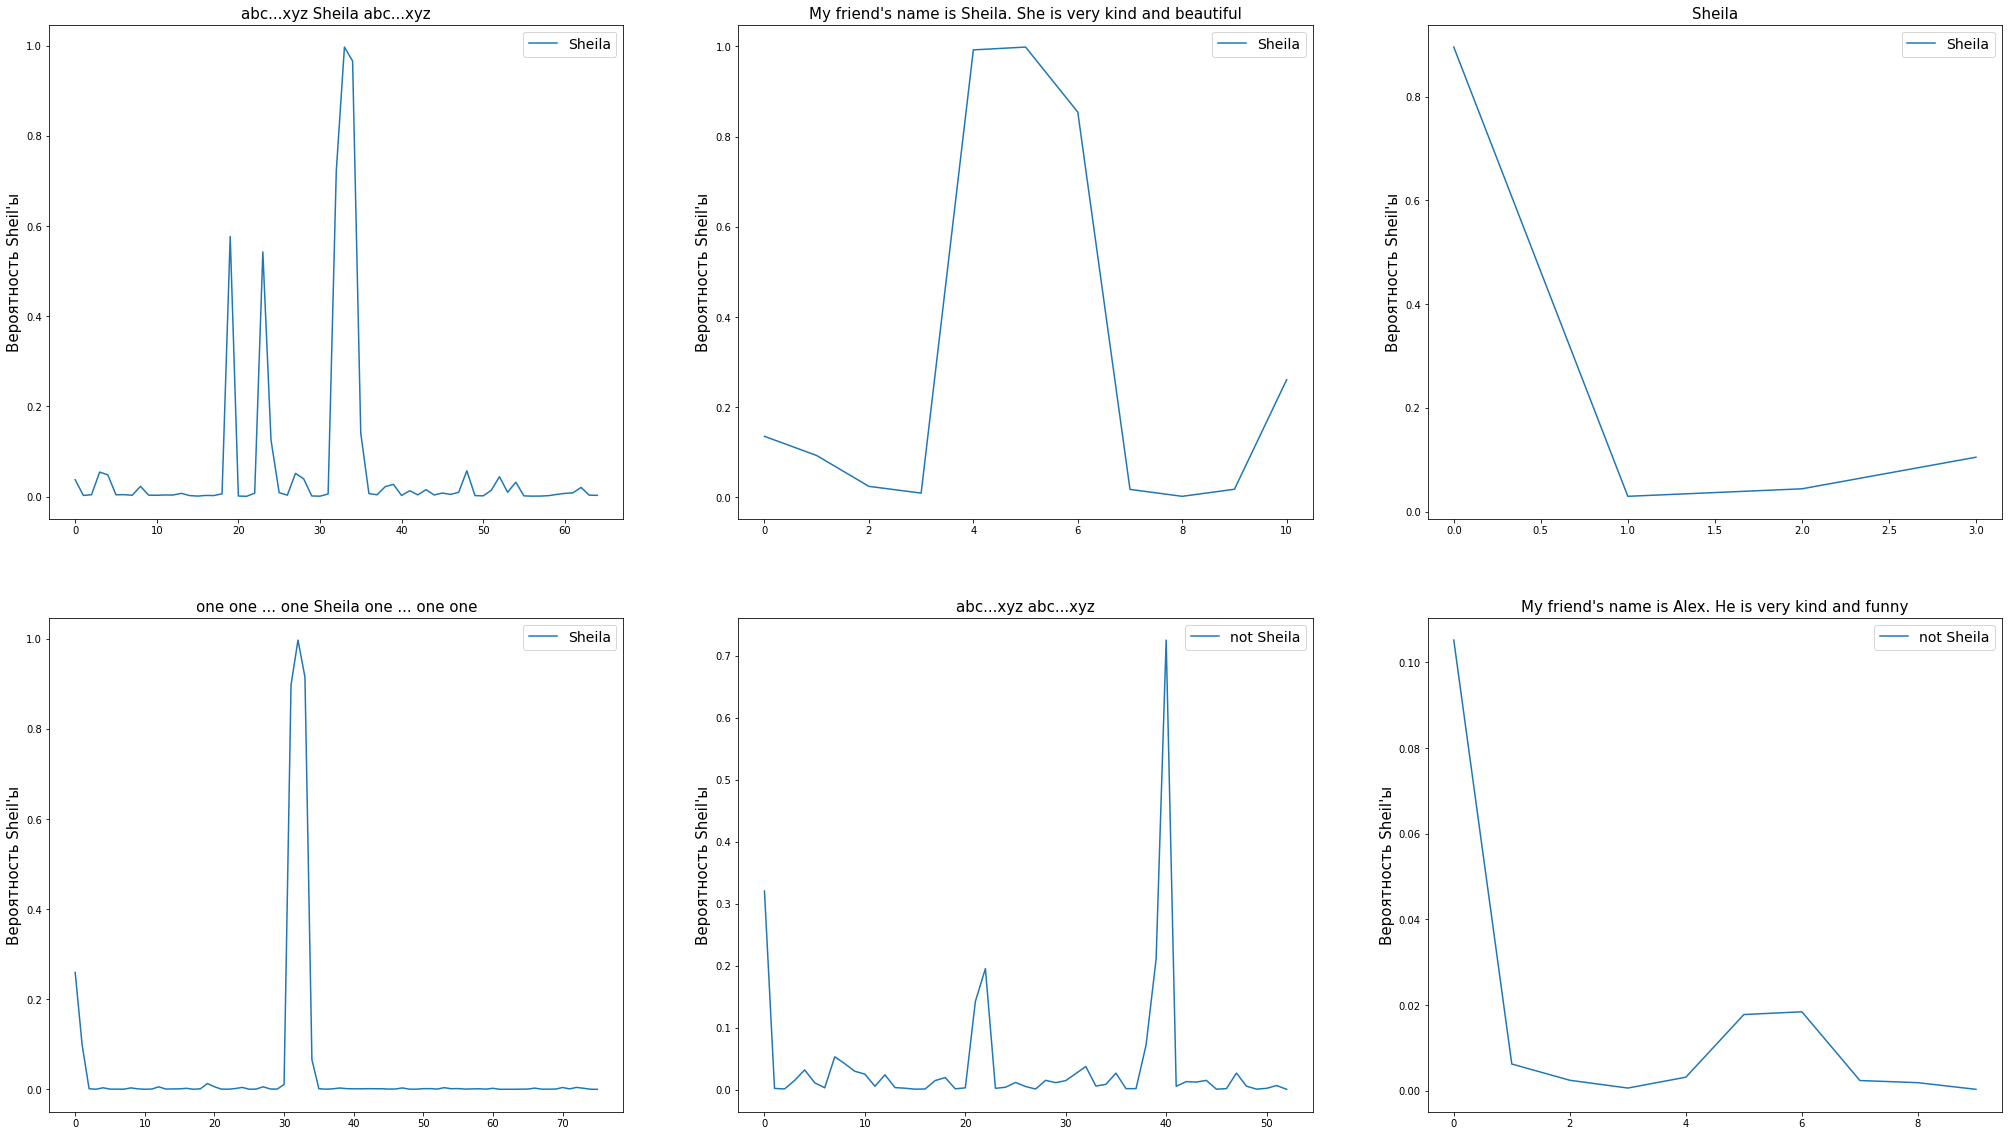

In [27]:
fig, axs = plt.subplots((len(probs_history) + 2) // 3, 3, figsize=(35,20))
for i, path in enumerate(probs_history):
    raw, col = i // 3, i - (i // 3) * 3
    axs[raw, col].plot(range(len(probs_history[path])), probs_history[path] , label=title_dict[path][1])
    axs[raw, col].legend(fontsize=14)
    axs[raw, col].set_title(title_dict[path][0], fontsize=15)
    axs[raw, col].set_ylabel("Вероятность Sheil'ы", fontsize=15)
plt.show()

## Best Compressed Model Results

In [28]:
PATH_TO_BEST_MODEL = "kws/models/best_model"
PATH_TO_BEST_MODEL_WITHOUT_QUANT = "kws/models/best_model_before_quant"
PATH_TO_BASE_MODEL = "kws/models/teacher"

In [29]:
best_model = torch.load(PATH_TO_BEST_MODEL)
base_model = torch.load(PATH_TO_BASE_MODEL)
prev_best_model = torch.load(PATH_TO_BEST_MODEL_WITHOUT_QUANT)

In [30]:
# результат оказался зависимым от среды выполнения в колабе
# при GPU она меньше 5.5e-5
# при CPU она больше 5.5e-5

melspec_val = LogMelspec(is_train=False, config=TaskConfig(device=torch.device("cpu")))

fa_fr_rate = validation(best_model, val_loader, melspec_val, device="cpu")

melspec_val = LogMelspec(is_train=False, config=TaskConfig)

fa_fr_rate

100%|██████████| 102/102 [00:08<00:00, 12.03it/s]


4.8480356549032876e-05

In [32]:
# Memory Comprisseion ratio 8.94 при первом запуске и 9.14 при втором (не очень знаю, с чем это связано) 

base_model_mb = get_size_in_megabytes(base_model)
best_model_mb = get_size_in_megabytes(best_model)

inp = torch.randn(1, 2 * 16_000)
spec = melspec_val(inp.to("cuda:0"))

best_model_macs = profile(prev_best_model, (spec, ))[0]
base_model_macs = profile(base_model, (spec, ))[0]

print()
print(f"Memory compression ratio (base_model : best_model) = {base_model_mb / best_model_mb}")
print(f"MACs compression ratio (base_model : best_model) = {base_model_macs / best_model_macs}")

[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.container.Sequential'>.
[INFO] Register count_gru() for <class 'torch.nn.modules.rnn.GRU'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.container.Sequential'>.
[INFO] Register count_gru() for <class 'torch.nn.modules.rnn.GRU'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.

Memory compression ratio (base_model : best_model) = 9.140887034987657
MACs compression ratio (base_model : best_model) = 4.04192917079971
